# Edinburgh Cycle Scheme Model
#### MMCS Project - 2025/26 
#### Erin Fortin, Alice Locker, Angel Ezeokoli, Katheryne Davis

### 0. Preliminaries

In [1]:
import os
print(os.getcwd())
os.environ["XPAUTH_PATH"] = r"C:\xpressmp\bin\xpauth.xpr"

C:\Users\alice\OneDrive - University of Edinburgh\Masters\Sem1\MMCS\Project


In [1]:
### Import Packages
import glob
import zipfile
import pandas as pd
import numpy as np 
import random
import xpress as xp
from sklearn.neighbors import NearestNeighbors, KernelDensity
from sklearn.cluster import KMeans, MiniBatchKMeans, DBSCAN
import matplotlib.pyplot as plt
import geopandas as gpd

### Set seeds for reproducibility
random.seed(42)
rng = np.random.default_rng(42)
xp.controls.randomseed = 42           # solver RNG seed
xp.controls.mipconcurrentsolves = 0     # disable concurrent solves (each concurrent solve uses different RNG)
xp.controls.mipthreads = 1  

### 1. Data PreProcessing

#### Remake `edinburgh_pois` Data Frame by clustering unnamed residential POIs and Commerical POIs

In [2]:
### Load Edinburgh POI Data    
edinburgh_pois = pd.read_csv("edinburgh_pois.csv")
print(f"Current POI count: {len(edinburgh_pois)}")

# --------------Remove primary schools from dataframe (scheme age requirement is 16)----------------
remove_schools = (edinburgh_pois['category'] == 'school') & edinburgh_pois['name'].str.contains('primary|nursery', case=False, na=False)
edinburgh_pois = edinburgh_pois[~remove_schools].copy()

print(f"Removed {remove_schools.sum()} nurseries and primary schools from the POI dataframe.")
print(f"Current POI count: {len(edinburgh_pois)}")

#---------------Cluster Unnamed Residential POIs----------------
# Separate residential POIs into named (apartment complexes/university accommodations) and unnamed (single-family homes)
res_named_cond = (edinburgh_pois["category"] == "residential") & edinburgh_pois["name"].notna() & (edinburgh_pois["name"] != "")
res_unnamed_cond = (edinburgh_pois["category"] == "residential") & (edinburgh_pois["name"].isna() | (edinburgh_pois["name"] == ""))

# Split and relabel categories
res_named = edinburgh_pois[res_named_cond].copy()
res_named["category"] = "residential_named"   

res_unnamed = edinburgh_pois[res_unnamed_cond].copy()
res_unnamed["category"] = "residential_unnamed"  

# count number of unnamed residential POIs
unnamed_coords = res_unnamed[["lat", "lon"]].to_numpy()
n_unnamed = unnamed_coords.shape[0]  # count how many

# Cluster unnamed residential POIs using KMeans to reduce their number
cluster_size = 20                                                                   # CHANGED TO 20
k = max(1, n_unnamed // cluster_size)

print(f"Clustering unnamed residential POIs into k = {k} clusters of ~{cluster_size} points each...")

kmeans = MiniBatchKMeans(n_clusters=k,batch_size=5000,random_state=0)
labels = kmeans.fit_predict(unnamed_coords)
centroids = kmeans.cluster_centers_

res_unnamed_clustered = pd.DataFrame({
    "lat": centroids[:, 0],
    "lon": centroids[:, 1],
    "category": "residential_unnamed",
    "name": None,
})

print(f"Reduced unnamed residential POIs from {n_unnamed} to {len(res_unnamed_clustered)}.")

#-----------------Cluster commerical POIs into business parks-----------------
# business parks must have at least 10 commercial POIs all within 200m of each other
commercial = edinburgh_pois[(edinburgh_pois["category"] == "commercial")].copy()

if len(commercial) > 0:
    print(f"Clustering {len(commercial)} commercial POIs into business parks...")

    # Convert to radians for haversine
    com_coords_rad = np.radians(commercial[["lat", "lon"]].to_numpy())

    # eps = 200m in radians on Earth
    eps_m = 200
    eps_rad = eps_m / 6371000  # Earth radius

    min_cluster_size = 10
    db = DBSCAN(eps=eps_rad,min_samples=min_cluster_size,metric="haversine").fit(com_coords_rad)

    commercial["cluster_id"] = db.labels_

    # Extract real clusters only (label >= 0)
    clustered_groups = commercial[commercial["cluster_id"] >= 0].groupby("cluster_id")

    commercial_cluster_centroids = []

    for cluster_id, group in clustered_groups:
        lat_c = group["lat"].mean()
        lon_c = group["lon"].mean()
        commercial_cluster_centroids.append((lat_c, lon_c))

    # Convert to dataframe
    commercial_cluster_centroids = pd.DataFrame(commercial_cluster_centroids, columns=["lat", "lon"])
    commercial_cluster_centroids["category"] = "commercial_cluster"
    commercial_cluster_centroids["name"] = None

    print(f"Identified {len(commercial_cluster_centroids)} commercial clusters of size > {min_cluster_size}.")

    # Keep unclustered commercial POIs separately
    commercial_unclustered = commercial[commercial["cluster_id"] == -1].copy()
    commercial_unclustered = commercial_unclustered.drop(columns=["cluster_id"])
else:
    commercial_cluster_centroids = pd.DataFrame(columns=["lat", "lon", "category", "name"])
    commercial_unclustered = pd.DataFrame()
    print("No commercial POIs to cluster.")



# ----------------Recombine into single POI dataframe------------------
other = edinburgh_pois[~(res_named_cond | res_unnamed_cond | (edinburgh_pois["category"] == "commercial"))].copy()
edinburgh_pois = pd.concat([other, res_named, res_unnamed_clustered, commercial_unclustered, commercial_cluster_centroids], ignore_index=True)

print("Finished recombining POIs.")
print(f"New POI count: {len(edinburgh_pois)}")

Current POI count: 33669
Removed 104 nurseries and primary schools from the POI dataframe.
Current POI count: 33565
Clustering unnamed residential POIs into k = 1639 clusters of ~20 points each...
Reduced unnamed residential POIs from 32782 to 1639.
Clustering 551 commercial POIs into business parks...
Identified 11 commercial clusters of size > 10.
Finished recombining POIs.
New POI count: 2136


####  Create `historical_trips` Data Frame from cyclehire-data

In [3]:
### Load Historical trip data
with zipfile.ZipFile("cyclehire-data.zip", "r") as zip_ref:
    zip_ref.extractall("cyclehire-data")
files = glob.glob("cyclehire-data/**/*.csv", recursive=True)   

if files:
    df_list = [pd.read_csv(f) for f in files]
    historical_trips = pd.concat(df_list, ignore_index=True)
else:
    raise FileNotFoundError("No CSV files found in cyclehire-data folder.")
    

# Create master list of unique stations with coordinates
starts = historical_trips[['start_station_id', 'start_station_latitude', 'start_station_longitude']].rename(
    columns={
        'start_station_id': 'station_id',
        'start_station_latitude': 'lat',
        'start_station_longitude': 'lon'
    }
)
ends = historical_trips[['end_station_id', 'end_station_latitude', 'end_station_longitude']].rename(
    columns={
        'end_station_id': 'station_id',
        'end_station_latitude': 'lat',
        'end_station_longitude': 'lon'
    }
)
stations = pd.concat([starts, ends], ignore_index=True)
stations = stations.drop_duplicates(subset=['station_id'])
stations = stations.reset_index(drop=True)
stations = stations[stations['station_id'] != 280] # Outlier station with odd coordinates 

### 2. Estimate Demand 
Use historical trip data to estimate the demand of the POI categories 


In [4]:
# Aggregate trips by start location
start_demand = historical_trips.groupby([
    'start_station_latitude', 'start_station_longitude'
]).size().reset_index(name='trip_count')

# Method 1: KNN-based demand estimation
poi_coords = np.radians(edinburgh_pois[['lat', 'lon']].values)
trip_coords = np.radians(start_demand[['start_station_latitude', 'start_station_longitude']].values)
trip_counts = start_demand['trip_count'].values

# Find nearest historical stations for each POI
nbrs = NearestNeighbors(n_neighbors=5, metric='haversine', radius=0.5/6371)
nbrs.fit(trip_coords)
distances, indices = nbrs.kneighbors(poi_coords)

# Calculate weighted demand
edinburgh_pois['knn_demand'] = 0.0
for i, (dists, idxs) in enumerate(zip(distances, indices)):
    if len(idxs) > 0:
        weights = 1 / (dists + 0.001)  # Inverse distance weighting
        weights = weights / weights.sum()
        weighted_demand = np.sum(trip_counts[idxs] * weights)
        edinburgh_pois.loc[i, 'knn_demand'] = round(weighted_demand)

# Normalise to reasonable scale by catgeory
# Dictionary of target averages per category
target_avgs = {
    "commercial": 0.5,
    "commercial_cluster": 6,
    "hospital": 0.5,
    "library": 0.5,
    "school": 0.5,
    "university": 6,
    "residential_named": 1,
    "residential_unnamed": 0.25
}

# For each category, apply individual rescaling
edinburgh_pois["final_demand"] = 0.0

for cat, target in target_avgs.items():
    # find average of demand in category 'cat'
    cond = edinburgh_pois["category"] == cat
    current_avg = edinburgh_pois.loc[cond, "knn_demand"].mean()

    # scale to be centred on target_avg(cat)
    if current_avg > 0:
        edinburgh_pois.loc[cond, "final_demand"] = (edinburgh_pois.loc[cond, "knn_demand"] * (target / current_avg)).round()

In [5]:
# Check demand distribution
summary = (
    edinburgh_pois
    .groupby("category")["final_demand"]
    .agg(count="count", mean="mean", min="min", max="max", sum="sum")
)

print(summary)
print(edinburgh_pois["final_demand"].sum())

                     count      mean  min   max    sum
category                                              
commercial             254  0.421260  0.0   2.0  107.0
commercial_cluster      11  5.818182  1.0  11.0   64.0
hospital                16  0.437500  0.0   1.0    7.0
library                 49  0.448980  0.0   1.0   22.0
residential_named       55  0.927273  0.0   3.0   51.0
residential_unnamed   1639  0.118365  0.0   1.0  194.0
school                  84  0.416667  0.0   2.0   35.0
university              28  6.000000  1.0  18.0  168.0
648.0


### Stochastic Demand
To model realistic demand variability over times.

#### Estimate Temporal Multipliers from Historical Data

In [6]:
# Convert start times to datetime format
df = historical_trips.copy()
df['started_at'] = pd.to_datetime(historical_trips["started_at"], utc=True, format="mixed")

df['dow']   = df['started_at'].dt.dayofweek        # 0=Mon..6=Sun
df['month'] = df['started_at'].dt.month - 1        # 0=Jan..11=Dec
df['hour']  = df['started_at'].dt.hour             # 0–23

# Multipliers
# f_dow
dow_counts = df.groupby('dow').size()
f_dow = (dow_counts / dow_counts.mean()).to_numpy()

# f_month
month_counts = df.groupby('month').size()
f_month = (month_counts / month_counts.mean()).to_numpy()

# f_hour
hour_counts = df.groupby('hour').size()
f_hour = (hour_counts / hour_counts.mean()).to_numpy()

print("Day-of-week multipliers f_dow:", f_dow)
print("Month multipliers f_month:", f_month)
print("Hour-of-day multipliers f_hour:", f_hour)

Day-of-week multipliers f_dow: [0.91999653 0.93958385 0.95575214 0.9776948  1.00989461 1.12975871
 1.06731936]
Month multipliers f_month: [0.5060186  0.526077   0.84240049 0.96728354 1.52167674 1.40153477
 1.44253726 1.49296979 1.13176238 0.95845264 0.72462906 0.48465772]
Hour-of-day multipliers f_hour: [0.29186267 0.19245639 0.14660863 0.10336586 0.09284171 0.16083186
 0.33531385 0.74283792 1.00182566 1.03438799 1.23653493 1.54434012
 1.8167696  1.90408874 1.92544963 2.05241667 2.21449892 2.05293766
 1.53100259 1.12650031 0.84985076 0.6887584  0.53183402 0.42268509]


#### Generate Demand Scenarios

In [7]:
def simulate_demand_scenarios(
        D_base,          # baseline demand per POI (float array)
        f_dow,           # array length 7
        f_month,         # array length 12
        f_hour,          # array length 24
        S=50,            # number of scenarios
        sigma=0.25,      # multiplicative random disturbance
        weights = None   # scenario weights (default is equal weights), array of length S
        ):

    # probability/weight of each scenario - normalise to sum to 1
    if weights is None:
        weights = np.ones(S) / S
    else:
        weights = np.array(weights)
        weights = weights / weights.sum()
    
    rng = np.random.default_rng(42)
    J = len(D_base)

    # create array to store demand at POI j in J under scenario s in S in entry [s,j]
    D_scenarios = np.zeros((S, J))

    # loop over scenarios
    for s in range(S):
        dow   = rng.integers(0, 7)
        month = rng.integers(0, 12)
        hour  = rng.integers(0, 24)

        # random multiplicative uncertainty factors for demand (lognormal so always positive)
        # these model uncertainty in demand - unexpected variation, e.g. events, traffic, other unobserved factors
        shocks = rng.lognormal(mean=0, sigma=sigma, size=J)

        # temporal scaling
        D_s = D_base * f_dow[dow] * f_month[month] * f_hour[hour] * shocks

        D_scenarios[s] = D_s

    
    # Expected demand across scenarios
    expected_demand = np.average(D_scenarios, axis=0, weights=weights)

    return D_scenarios, weights, expected_demand


# use function to generate scenarios
D_eff = edinburgh_pois['final_demand'].values
D_scenarios, weights, expected_demand = simulate_demand_scenarios(D_eff, f_dow, f_month, f_hour, S=500, sigma=0.25)

In [8]:
comparison_df = pd.DataFrame({
    "final_demand": edinburgh_pois["final_demand"],
    "expected_demand": pd.Series(expected_demand, index=edinburgh_pois.index)
})

comparison_df.describe()

,final_demand,expected_demand
count,2136.000000,2136.000000
mean,0.303371,0.340642
std,1.066724,1.202839
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,18.000000,20.790590


### 3. K-Means Clustering to make new Candidate Stations

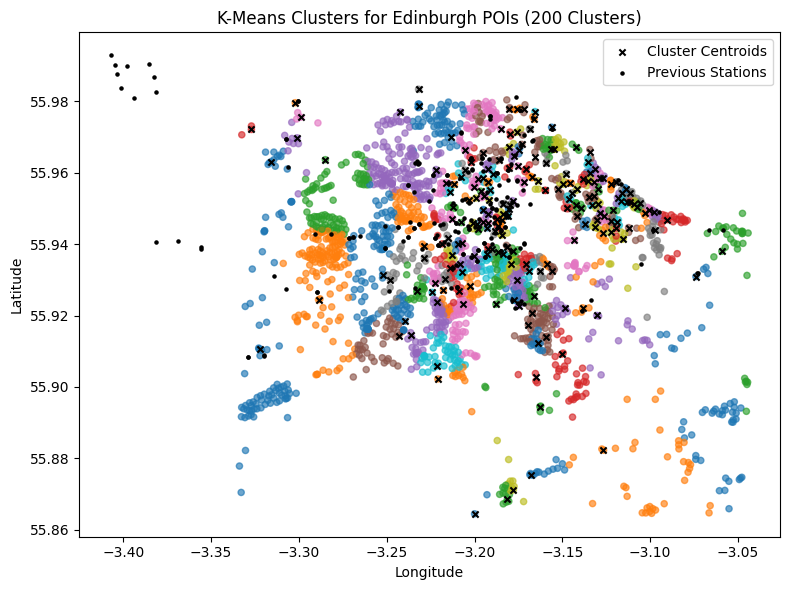

In [9]:
demand_weights = expected_demand

n_candidates = 200  # Total candidate stations
    
km = KMeans(n_clusters=n_candidates, random_state=42)
km.fit(edinburgh_pois[['lat', 'lon']].values, sample_weight=demand_weights)
    
new_station_centers = km.cluster_centers_
    
# Combine with existing stations
existing_coords = stations[['lat', 'lon']].values
candidate_stations = np.vstack([existing_coords, new_station_centers])
    
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(edinburgh_pois["lon"], edinburgh_pois["lat"], c=km.labels_, cmap='tab10', s=20, alpha=0.65)
plt.scatter(new_station_centers[:, 1], new_station_centers[:, 0], c='black', s=20, marker='x', label='Cluster Centroids')
plt.scatter(stations["lon"], stations["lat"], c='black', s=20, marker='.', label='Previous Stations')

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title(f"K-Means Clusters for Edinburgh POIs ({n_candidates} Clusters)")
plt.legend()
plt.tight_layout()
plt.show()

### 4. Model Parameters

In [10]:
parameters_dict = {
    'demand_target_coverage': 0.7,         # Target demand coverage
    'geo_target_coverage': 0.3,            # Target geographical coverage
    'demand_category_targets': {           # Demand coverage targets by catgeory
                        "library": 0.4,
                        "school": 0.4,
                        "university": 0.7,
                        "commercial": 0.6,
                        "commercial_cluster": 0.7,
                        "hospital": 0.4,
                        "residential_named": 0.4,
                        "residential_unnamed": 0.3}, 
    'geo_category_targets' : {            # Geographical coverage targets by category
                        "library": 0.1,
                        "school": 0.1,
                        "university": 0.25,
                        "commercial": 0.25,
                        "commercial_cluster": 0.2,
                        "hospital": 0.1,
                        "residential_named": 0.1,
                        "residential_unnamed": 0.1}, 
    'implementation_cost': 3000000, # initial implementation cost (app, hiring people)
    'budget': 20000000,             # Total capital budget available (roughly equal to the total transportation budget )
    'fleet_size': 500,             # Total number of bikes available
    'station_cost': 45000,          # Cost per station
    'bike_cost': 2000,              # Cost per bike
    'dock_cost': 3000,              # Cost per dock
    'max_docks_per_station': 40,    # Maximum docks allowed per station
    'min_docks_per_station': 6,     # Minimum docks required to open a station
    'coverage_radius_km': 0.3,      # Coverage radius in kilometers
    'daily_bike_op_cost': 1.5,      # Daily operational cost per bike
    's_trips_per_bike_per_day': 5,  # Trips served per bike per day
    'T_days': 365,                  # Number of operational days per year
    'r_annual': 0.035,              # Annual discount rate
    'num_employers': 5,             # Number of employers contributing capital
    'K_e': 200000,                  # Capital contribution per employer
    'K_sponsor': 2000000,           # Sponsor investment
    'per_ride_fare': 3.5,          # Fare per ride
    'prop_subsidised': 0.5          # Proportion of trip price subsidised by employer for employees               
}

### 5. Set Up Model Components
- Distance matrix
- Category Mapping (for category-based target coverage)
- Sample Employer Affiliation

In [11]:
# === Index Sets ===
num_stations = candidate_stations.shape[0]
num_pois = edinburgh_pois.shape[0]
I = range(num_stations)  # Candidate stations
J = range(num_pois)      # POIs

# === Import Parameters from Dictionary ===
demand_target_coverage = parameters_dict['demand_target_coverage']
geo_target_coverage = parameters_dict['geo_target_coverage']
demand_category_targets = parameters_dict['demand_category_targets']
geo_category_targets = parameters_dict['geo_category_targets']
implementation_cost = parameters_dict['implementation_cost']
budget = parameters_dict['budget']
fleet_size = parameters_dict['fleet_size']
station_cost = parameters_dict['station_cost']
bike_cost = parameters_dict['bike_cost']
dock_cost = parameters_dict['dock_cost']
max_docks_per_station = parameters_dict['max_docks_per_station']
min_docks_per_station = parameters_dict['min_docks_per_station']   
coverage_radius_km = parameters_dict['coverage_radius_km'] 
daily_bike_op_cost = parameters_dict['daily_bike_op_cost']
s_trips_per_bike_per_day = parameters_dict['s_trips_per_bike_per_day']
T_days = parameters_dict['T_days']
r_annual = parameters_dict['r_annual']
num_employers = parameters_dict['num_employers']
K = parameters_dict['K_e'] * np.ones(num_employers)
K_sponsor = parameters_dict['K_sponsor']
p = parameters_dict['per_ride_fare']
prop_subsidised = parameters_dict['prop_subsidised']                                                          # ADDED 

# ----------------- Distance Matrix for Station-POI coverage ---------------------
station_lats = candidate_stations[:, 0]
station_lons = candidate_stations[:, 1]
poi_lats = edinburgh_pois['lat'].to_numpy()
poi_lons = edinburgh_pois['lon'].to_numpy()

# Convert all to radians
lat1 = np.radians(poi_lats)[:, np.newaxis]  # shape (num_demand,1)
lon1 = np.radians(poi_lons)[:, np.newaxis]
lat2 = np.radians(station_lats)[np.newaxis, :]  # shape (1,num_stations)
lon2 = np.radians(station_lons)[np.newaxis, :]

# Haversine formula (converting from lat and lon to km)
dlat = lat2 - lat1
dlon = lon2 - lon1
a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
central_angle = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
R = 6371.0

# matrix (J,I) of distances between each POI and each station
distances = R * central_angle  # shape: (num_pois, num_stations) - distance of each poi from each station

# ------------------- Coverage Matrix --------------------
closest_station = np.argmin(distances, axis=1)   # length J, index of closest station for each POI j
a = np.zeros_like(distances, dtype=int)

# a[j,i] = 1 only if i is the closest station to j and it is within the coverage radius
for j in J:
    i = closest_station[j]
    if distances[j, i] <= coverage_radius_km:
        a[j, i] = 1


# ------------------- Distance Matrix for Station-Station Separation -----------------
station_lats = candidate_stations[:, 0]
station_lons = candidate_stations[:, 1]

lat1 = np.radians(station_lats)[:, np.newaxis]  # shape (num_stations,1)
lon1 = np.radians(station_lons)[:, np.newaxis]
lat2 = np.radians(station_lats)[np.newaxis, :]  # shape (1,num_stations)
lon2 = np.radians(station_lons)[np.newaxis, :]

dlat = lat2 - lat1
dlon = lon2 - lon1
a_stations = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
central_angle_stations = 2 * np.arctan2(np.sqrt(a_stations), np.sqrt(1 - a_stations))
R = 6371.0  # Earth radius in km

distances_stations = R * central_angle_stations  # shape: (num_stations, num_stations)


# Demand Vector
D = expected_demand
total_demand = D.sum()

# === Category Mapping ===
categories = edinburgh_pois['category'].unique()
category_indices = {}
category_demands = {}

for cat in categories:
    cat_mask = edinburgh_pois['category'] == cat
    category_indices[cat] = np.where(cat_mask)[0]
    category_demands[cat] = D[cat_mask].sum()

# === Sample Employer Affiliations ===
n = np.zeros((num_employers, num_pois), dtype=int)

# assign probs of trip from each category POI being subsisied by any employer
p_no_emp_dict = {
    "library": 0.95,
    "school": 0.99,
    "university": 0.85,
    "hospital": 0.95,
    "commercial": 0.7,
    'commercial_cluster': 0.5,
    "residential_named": 0.9,
    "residential_unnamed": 0.8
}


# for each POI, sample Dj assignments among employers + none
for j in J:
    if D[j] <= 0:
        continue
    # get category
    cat = edinburgh_pois.loc[j, 'category']

    # split residential category
    if cat == 'residential':
        if pd.notna(edinburgh_pois.loc[j, 'name']) and edinburgh_pois.loc[j, 'name'] != '':
            cat = 'residential_named'
        else:
            cat = 'residential_unnamed'

    # get prob that they are not/they are employed (by one of the subsidising employers)
    p_no_emp = p_no_emp_dict[cat]
    emp_mass = 1 - p_no_emp

    # if there are no employers or no trip from POI j is subsidised, skip to next j (all n[e,j]=0)
    if num_employers == 0 or emp_mass == 0.0:
        continue
        
    # distribute employer mass equally 
    rng = np.random.default_rng(42)
    emp_probs = np.ones(num_employers) / num_employers * emp_mass
    full_probs = np.concatenate((emp_probs, [p_no_emp]))  # last index means 'none' (trip not subsidised)
    indices = np.append(np.arange(num_employers), num_employers)  # makes array [0,1,...,num_employers]
    assigned = rng.choice(indices, size=round(D[j]), p=full_probs)  # draw Dj independent samples from indices
    for e in range(num_employers):
        n[e, j] = int(np.sum(assigned == e))

            
# average per-ride subsidy for employees     
# use average price after solving model as p
s_e = np.ones(num_employers) * p * prop_subsidised                                                

# total employer capital
K_total = float(K.sum())


# Calculate effective demand (after subsidies)                                                     
# PED parameter
PED = -0.4 

# assume s_e is vector of employer subsidy per subsidised trip (shape (num_employers,))
# n is (num_employers, num_pois) counts of subsidised trips
raw_subsidy = np.sum(s_e[:, None] * n, axis=0)            # total subsidy £ at POI j
num_subsidised_trips = np.sum(n, axis=0)                 # number of subsidised trips at POI j
valid = D > 0                                            # only points with positive demand have subsidised trips

# subsidy per subsidised trip (avoid division by zero)
subsidy_per_subsidised_trip = np.zeros_like(raw_subsidy, dtype=float)
has_sub = num_subsidised_trips > 0
subsidy_per_subsidised_trip[has_sub] = raw_subsidy[has_sub] / num_subsidised_trips[has_sub]

# Ensure subsidy per subsidised trip doesn't exceed fare
subsidy_per_subsidised_trip = np.minimum(subsidy_per_subsidised_trip, p)

# prices
price_sub = np.maximum(p - subsidy_per_subsidised_trip, 0.01)  # price for subsidised trips
price_unsub = p                                             # price for unsubsidised trips

# fraction of trips that are subsidised
frac_sub = np.zeros_like(D, dtype=float)
frac_sub[valid] = num_subsidised_trips[valid] / D[valid]

# compute effective demand (no rounding yet)
D_subsidised = np.zeros_like(D, dtype=float)
D_unsubsidised = np.zeros_like(D, dtype=float)

D_subsidised[valid] = D[valid] * frac_sub[valid] * (price_sub[valid] / p) ** PED
D_unsubsidised[valid] = D[valid] * (1 - frac_sub[valid])  # unchanged price

D_eff_float = D_subsidised + D_unsubsidised

# Round up if fractional part >0.75
int_part = np.floor(D_eff_float)
frac_part = D_eff_float - int_part

# Round based on threshold
D_eff = int_part + (frac_part > 0.14)
D_eff = D_eff.astype(int)

# Replace demand vector with effective demand
previous_total_demand = D.sum()
D = D_eff
total_demand = D.sum()
print('Demand Increase:', total_demand - previous_total_demand)

Demand Increase: 42.38869227483406


### 6. Build the Model

In [13]:
price = xp.problem(name='price_model')
price.controls.randomseed = 42

# === Decision Variables ===
x = [price.addVariable(name=f'x_{i}', vartype=xp.integer, lb=0) for i in I]   # bikes per station
docks = [price.addVariable(name=f'docks_{i}', vartype=xp.integer, lb=0) for i in I]
y = [price.addVariable(name=f'y_{i}', vartype=xp.binary) for i in I]          # open station
z = [price.addVariable(name=f'z_{j}', vartype=xp.binary) for j in J]          # is POI j at least partially covered?
served_station = [price.addVariable(name=f'served_{i}', vartype=xp.integer, lb=0) for i in I]  # how many trips at station i are served

# === Objective: minimize capital net cost for council ===
net_council_cost = xp.Sum([station_cost * y[i] + dock_cost * docks[i] + bike_cost * x[i] for i in I]) \
                   + implementation_cost - K_total - K_sponsor
price.setObjective(net_council_cost, sense=xp.minimize)


# === CONSTRAINTS ===
# Station size constraints
for i in I:
    price.addConstraint(2 * x[i] == docks[i])
    price.addConstraint(docks[i] <= max_docks_per_station * y[i])
    price.addConstraint(docks[i] >= min_docks_per_station * y[i])
    price.addConstraint(x[i] >= y[i])  # at least one bike if station is open

# Fleet limit
price.addConstraint(xp.Sum(x[i] for i in I) <= fleet_size)

# Total demand coverage constraint
price.addConstraint(xp.Sum(served_station[i] for i in I) >= demand_target_coverage * total_demand)

# Total geographical coverage constraint
price.addConstraint(xp.Sum(z[j] for j in J) >= geo_target_coverage * len(J))

# Demand coverage by catgeory constraints
for cat, target in demand_category_targets.items():
    idxs = category_indices[cat]
    price.addConstraint(xp.Sum(D[j] for j in idxs) * target <=xp.Sum(served_station[closest_station[j]] for j in idxs))

# Geographical coverage by category constraints
for cat, target in geo_category_targets.items():
    idxs = category_indices[cat]  
    price.addConstraint(xp.Sum(z[j] for j in idxs) >= target * len(idxs))


# Station service constraints
# Each station cannot serve more trips than its bike capacity allows
for i in I:
    price.addConstraint(served_station[i] <= s_trips_per_bike_per_day * x[i])

    # cannot serve more trips at station i than sum of demand from covered POIs j
    covered_POIs = [j for j in J if closest_station[j] == i and a[j, i] == 1]

    # If station covers no POIs → served_station must be zero
    if len(covered_POIs) == 0:
        price.addConstraint(served_station[i] == 0)
    else:
        price.addConstraint(served_station[i] <= sum(D[j] for j in covered_POIs)* y[i]) 

# POI coverage: z[j] = 1 when its closest station is open
for j in J:
    price.addConstraint(z[j] == y[closest_station[j]] * a[j, closest_station[j]])
    
# Budget constraint
price.addConstraint(xp.Sum([station_cost * y[i] + dock_cost * docks[i] + bike_cost * x[i] for i in I]) + implementation_cost <= budget + K_total + K_sponsor)


# Enforce that stations withing a certain distance of each oter cannot both be open
min_distance_km = 0.2

for i in I:
    for k in range(i+1, len(I)):
        if distances_stations[i, k] < min_distance_km:
            price.addConstraint(y[i] + y[k] <= 1)


price.write("pricing_model", "lp")
print('Model Building finished')

Model Building finished


### 7. Solving

In [14]:
xp.setOutputEnabled(False)

print('======== SOLVING MODEL ========')
price.solve()
print('======== MODEL SOLVING COMPLETE ========')

======== SOLVING MODEL ========
======== MODEL SOLVING COMPLETE ========


### 8. Analyze Results

In [15]:
import math

# compute and display MIP gap
best_obj = price.attributes.objval
best_bound = price.attributes.bestbound

if best_obj != 0:
    mip_gap = abs(best_obj - best_bound) / abs(best_obj)
else:
    mip_gap = float('inf')

print(f"MIP Gap: {mip_gap*100:.2f}%")


def write_solution():
    '''
    Function to write model outputs when solved optimally.
    '''
    print(f'Total Public Cost: £{price.attributes.objval:,.2f}')

    print()
    print('---------------Open Stations---------------')
    open_stations = [i for i in I if price.getSolution(y[i]) > 0.5] 
    print('Number of open stations:', len(open_stations))
    print("Open stations:", open_stations)

    #-----------Distribute served trips amongst covered POIs------------
    
    # Initialise served array for number of trips served per POI
    served = np.zeros(len(J))    
    
    # Precompute POIs served by each station (to avoid recomputing inside loops)
    station_POIs = {i: [j for j in J if closest_station[j] == i] for i in open_stations}
    
    # Distribute served_station[i] across POIs assigned to that station
    for i in open_stations:
        POIs_i = station_POIs[i]
        if not POIs_i:
            continue
    
        demand_i = round(sum(D[j] for j in POIs_i))
        served_i = round(price.getSolution(served_station[i]))
        
        if demand_i > 0:
            allocation_fraction = min(1, served_i / demand_i)
        else:
            allocation_fraction = 0
    
        # Allocate proportionally to demand
        for j in POIs_i:
            served[j] = round(allocation_fraction * D[j])


    for i in open_stations:
        print(f'  Station {i}: {price.getSolution(x[i]):.0f} bikes ({price.getSolution(docks[i]):.0f} docks)')


    total_bikes = int(sum(price.getSolution(x[i]) for i in open_stations))
    total_docks = int(sum(price.getSolution(docks[i]) for i in open_stations))
    coverage_pct = sum(round(price.getSolution(served_station[i])) for i in I)/total_demand*100
    
    print()
    print(f"Coverage achieved: {coverage_pct:.1f}%")
    print(f"Total bikes: {total_bikes}")
    print(f"Total docks: {total_docks}")
    print()
    
    
    # ----------Print coverage by category-----------
    total_served_demand = served.sum()
    total_geo_covered = sum(z[j].getSolution() for j in J)

    
    print('---------------Coverage Achieved---------------')
    print(f'Total demand coverage: {total_served_demand} / {total_demand} ({total_served_demand/total_demand:.2%})')
    print(f'Total geographical coverage: {total_geo_covered} / {len(J)} ({total_geo_covered/len(J):.2%})\n')
    
    # Per-category coverage
    for cat in categories:  
        idxs = category_indices[cat]
        cat_demand = D[idxs].sum()
        cat_served = served[idxs].sum()
        cat_geo_covered = sum(z[j].getSolution() for j in idxs)
        
        demand_frac = cat_served / cat_demand if cat_demand > 0 else 0
        geo_frac = cat_geo_covered / len(idxs) if len(idxs) > 0 else 0
        
        print(f'{cat:20} | Demand covered: {cat_served}/{cat_demand} ({demand_frac:.2%}) | Geo covered: {cat_geo_covered}/{len(idxs)} ({geo_frac:.2%})')
    print()

    
    # ---------------- Revenues ----------------
    # Daily trips served across all stations
    served_station_values = np.array([round(price.getSolution(served_station[i])) for i in I])
    served_open_station_values = np.array([round(price.getSolution(served_station[i])) for i in open_stations])
    daily_trips = served_station_values.sum()
    
    # Employer contribution: sum over all employers for trips they subsidize
    employer_revenue = 0
    for e in range(num_employers):
        employer_revenue += (n[e, :] * s_e[e]).sum()  # daily trips * per-ride subsidy
    
    total_daily_revenue = daily_trips * p
    user_revenue = total_daily_revenue - employer_revenue
    
    # Daily operating costs
    total_bikes = int(sum(price.getSolution(x[i]) for i in open_stations))
    daily_operating_cost = total_bikes * daily_bike_op_cost
    
    # Net daily cash flow
    daily_net_cashflow = total_daily_revenue - daily_operating_cost

    # Break-even calculations
    if daily_net_cashflow > 0:
        net_council_cost_value = price.attributes.objval
        break_even_days = net_council_cost_value / daily_net_cashflow  # net_council_cost_value = objective value
    else:
        break_even_days = float('inf')
    
    pv_annual = daily_net_cashflow * T_days  # simple PV over T_days (can add discounting if needed)
    
    # === Print output ===
    print("---------------Revenues---------------")
    print(f"Daily revenue from users: £{user_revenue:,.2f}")
    print(f"Daily revenue contribution from employers: £{employer_revenue:,.2f}")
    print(f"Total daily revenue: £{total_daily_revenue:,.2f}")
    print(f"Daily operating cost (bikes): £{daily_operating_cost:,.2f}")
    print(f"Total daily trips: {daily_trips}")
    print(f"Total daily demand: {D.sum()}")
    print()
    print("---------------Cash Flows---------------")
    print(f"Daily net cashflow (operational): £{daily_net_cashflow:,.2f}")
    print(f"Break-even days (undiscounted, if all revenue goes to council): {break_even_days}")
    print(f"PV net over {T_days} days: £{pv_annual:,.2f}")


    # --------------------- Funtion Returns ---------------------
    return served


status = price.attributes.solstatus

if status == 1:
    print("Optimal solution found.")
    served = write_solution()
elif status == 2:
    print("The problem is feasible but the solution is not optimal.")
elif status == 3:
    print("The problem is infeasible.")
elif status == 4:
    print("The problem is unbounded.")
else:
    print(f"Other status: {status}")


MIP Gap: 0.00%
Optimal solution found.
Total Public Cost: £8,052,000.00

---------------Open Stations---------------
Number of open stations: 116
Open stations: [2, 74, 137, 151, 153, 157, 166, 182, 197, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 213, 214, 215, 216, 217, 218, 219, 221, 222, 226, 227, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 245, 246, 251, 252, 253, 254, 255, 257, 260, 262, 264, 265, 270, 272, 273, 274, 276, 277, 278, 279, 284, 286, 288, 289, 292, 293, 294, 295, 296, 297, 298, 299, 301, 304, 307, 308, 310, 311, 312, 313, 314, 315, 316, 323, 324, 326, 328, 329, 332, 336, 338, 341, 342, 345, 347, 348, 349, 350, 352, 359, 360, 362, 363, 367, 369, 371, 377, 379, 381, 385, 387, 390, 391, 393, 395]
  Station 2: 3 bikes (6 docks)
  Station 74: 3 bikes (6 docks)
  Station 137: 3 bikes (6 docks)
  Station 151: 3 bikes (6 docks)
  Station 153: 3 bikes (6 docks)
  Station 157: 3 bikes (6 docks)
  Station 166: 3 bikes (6 docks)
  Station 182: 3 bikes (6 docks)


### 9. Plot Locations of Open Stations

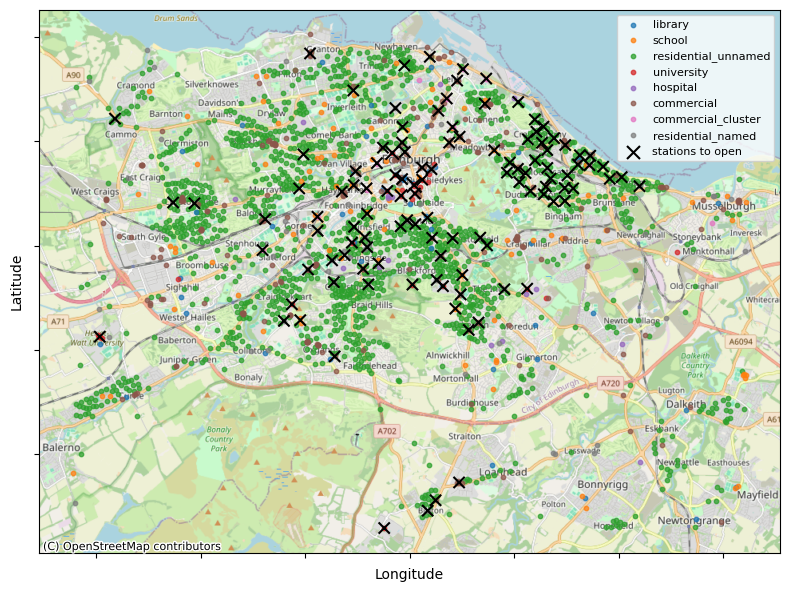

In [16]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from shapely.geometry import Point

category_conds_clustered = [
    edinburgh_pois["category"] == "library",
    edinburgh_pois["category"] == "school",
    edinburgh_pois["category"] == "residential_unnamed",
    edinburgh_pois["category"] == "university",
    edinburgh_pois["category"] == "hospital",
    edinburgh_pois["category"] == "commercial",
    edinburgh_pois["category"] == "commercial_cluster",
    edinburgh_pois["category"] == "residential_named"
]

# Plot POIs by category
cat_names = [
    "library",
    "school",
    "residential_unnamed",
    "university",
    "hospital",
    "commercial",
    "commercial_cluster",
    "residential_named"
]
# open station coordinates
open_stations = [i for i in I if price.getSolution(y[i]) > 0.5]
open_station_lats = station_lats[open_stations]
open_station_lons = station_lons[open_stations]

# find number of bikes at each station and scale marker size
open_station_bikes = np.array([price.getSolution(x[i]) for i in open_stations])
marker_sizes = 20 + 15 * open_station_bikes

# --- Convert POIs to GeoDataFrame ---
gdf_pois = gpd.GeoDataFrame(
    edinburgh_pois,
    geometry=gpd.points_from_xy(edinburgh_pois.lon, edinburgh_pois.lat),
    crs="EPSG:4326"
)

# --- Convert new stations to GeoDataFrame ---
gdf_stations = gpd.GeoDataFrame(
    geometry=gpd.points_from_xy(open_station_lons, open_station_lats),
    crs="EPSG:4326"
)

# --- Convert to Web Mercator (required for contextily) ---
gdf_pois_web = gdf_pois.to_crs(epsg=3857)
gdf_stations_web = gdf_stations.to_crs(epsg=3857)

# --- Plot ---
fig, ax = plt.subplots(figsize=(8, 6))

# Plot POIs by category
for label, cond in zip(cat_names, category_conds_clustered):
    df = gdf_pois_web[cond]

    # Give unnamed residential a different zorder (plot behind)
    if label == "residential_unnamed":
        df.plot(
            ax=ax,
            markersize=10,
            label=label,
            alpha=0.75,
            zorder=1
        )
    else:
        df.plot(
            ax=ax,
            markersize=10,
            label=label,
            alpha=0.75,
            zorder=2   # <-- normal
        )

# Plot new stations
gdf_stations_web.plot(
    ax=ax,
    markersize=marker_sizes,
    color="black",
    marker="x",
    label="stations to open",
    zorder=9
)

# --- Add basemap ---
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

# Cleanup
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("")
ax.legend(markerscale=1, fontsize=8)
ax.set_xticklabels([])
ax.set_yticklabels([])
plt.tight_layout()

plt.savefig("stations_POIs_plot.png") 

plt.show()


### 10. Simulate Trips

In [17]:
edinburgh_pois['nearest_station_idx'] = closest_station
edinburgh_pois['distance_to_nearest'] = [distances[j,closest_station[j]] for j in J]
served_pois = edinburgh_pois[(edinburgh_pois['nearest_station_idx'].isin(open_stations)) & (edinburgh_pois['distance_to_nearest']<=0.3)]

cat_names = [
"library",
"school",
"residential_unnamed",
"university",
"hospital",
"commercial",
"commercial_cluster",
"residential_named"
]
# Probability matrix as a dictionary of lists
prob_matrix = {
"library": [0.05, 0.05, 0.05, 0.05, 0.10, 0.40, 0.25, 0.05],
"school": [0.01, 0.40, 0.02, 0.02, 0.05, 0.35, 0.10, 0.05],
"university": [0.02, 0.03, 0.40, 0.03, 0.20, 0.15, 0.12, 0.05],
"hospital": [0.01, 0.01, 0.01, 0.10, 0.08, 0.60, 0.15, 0.04],
"residential_named": [0.02, 0.08, 0.25, 0.05, 0.10, 0.30, 0.15, 0.05],
"residential_unnamed": [0.02, 0.10, 0.08, 0.04, 0.05, 0.00, 0.45, 0.26],
"commercial": [0.03, 0.05, 0.05, 0.03, 0.05, 0.55, 0.10, 0.14],
"commercial_cluster": [0.01, 0.02, 0.03, 0.02, 0.04, 0.55, 0.10, 0.23]
}

# Build the DataFrame
prob_df = pd.DataFrame(prob_matrix, index=cat_names)

# Ensure each row sums to 1 (sanity check)
prob_df = prob_df.div(prob_df.sum(axis=1), axis=0)

def pick_poi(category, pois_df):
    subset = pois_df[pois_df['category'] == category]
    return subset.sample(1, random_state=42).iloc[0]

def generate_bike_trip(start_poi, prob_df, categories, pois_df, distances_stations):
    # --- Step 1: choose start POI ---
    start_poi_row = pois_df.loc[start_poi]
    start_station = int(start_poi_row['nearest_station_idx'])
    
    # --- Step 2: pick next category (destination POI category) ---
    probs_cat = prob_df.loc[start_poi_row["category"]].values
    end_category = rng.choice(categories, p=probs_cat)

    # Step 2.5: choose end_poi from chosen catgeory wit probability dependent on distance from start_poi
    candidates = pois_df[pois_df['category'] == end_category].copy()
    if candidates.empty:
        # pick any POI if category has no available POIs
        candidates = pois_df.copy()
    
    # compute distances from start station to candidate POIs' nearest stations
    end_station_indices = candidates['nearest_station_idx'].values
    eucl_distances = np.array([distances_stations[start_station, e] for e in end_station_indices])
    
    # double Euclidean distances to account for real roads
    trip_distances = eucl_distances * 2 
    
    # assign distance weights
    distance_probs = np.zeros_like(trip_distances)
    distance_probs[(trip_distances < 5)] = 0.3
    distance_probs[(trip_distances >= 5) & (trip_distances < 10)] = 0.4
    distance_probs[(trip_distances >= 10) & (trip_distances < 15)] = 0.2
    distance_probs[trip_distances >= 15] = 0.1
    
    # normalize to sum to 1
    distance_probs /= distance_probs.sum()
    
    # randomly select one candidate based on distance weights
    chosen_idx = rng.choice(candidates.index, p=distance_probs)
    
    
    # --- Step 3: choose end POI ---
    end_poi_row = pick_poi(end_category, pois_df)
    end_poi = int(end_poi_row.name)
    
    # --- Step 4: assign nearest stations ---
    end_station = int(end_poi_row['nearest_station_idx'])
    
    return {
    "start_poi": start_poi,
    "start_station": start_station,
    "end_station": end_station,
    "end_poi": end_poi,
    "start_category": start_poi_row['category'],
    "end_category": str(end_category),
    "trip_distance_km": float(round(trip_distances[candidates.index.get_loc(chosen_idx)], 2))
    }


trip = generate_bike_trip(
start_poi=1,
prob_df=prob_df,
categories=cat_names,
pois_df=served_pois,
distances_stations=distances_stations
)

print(trip)

{'start_poi': 1, 'start_station': 151, 'end_station': 205, 'end_poi': 2133, 'start_category': 'library', 'end_category': 'commercial_cluster', 'trip_distance_km': 14.42}


In [18]:
def simulate_mult_trips(start_poi, prob_df, categories, pois_df, distances_stations, n=1):
    trips=[]
    if n==0:
        return pd.DataFrame([])
    else:
        for _ in range(n):
            trips.append(generate_bike_trip(start_poi, prob_df, categories, pois_df,distances_stations))
    
    return pd.DataFrame(trips)
    
all_trips=[]
for j in served_pois.index.tolist():
    trips_df = simulate_mult_trips(j, prob_df, cat_names, served_pois,distances_stations, n=int(served[j]));
    all_trips.append(trips_df)
    
master_df = pd.concat(all_trips)


#---------------- Add ride duration and price columns -----------------
# Average speed in km/min
speed_km_per_min = 0.3

# Compute ride duration in minutes
master_df['ride_duration_min'] = round(master_df['trip_distance_km'] / speed_km_per_min, 1)

# Compute price: £2 for first 30 min, £1 per extra 10 min
base_p = 3
def compute_price(duration_min):
    if duration_min <= 30:
        return base_p
    else:
        extra_mins = duration_min - 30
        extra_units = math.ceil(extra_mins / 10)
        return base_p + extra_units

master_df['ride_price'] = master_df['ride_duration_min'].apply(compute_price)

master_df

,start_poi,start_station,end_station,end_poi,start_category,end_category,trip_distance_km,ride_duration_min,ride_price
0,5,274,205,2133,library,commercial_cluster,3.73,12.4,3
0,10,332,265,7,school,school,6.96,23.2,3
0,15,307,151,1,school,library,1.37,4.6,3
0,21,315,234,91,library,hospital,5.32,17.7,3
0,24,293,360,1570,library,residential_unnamed,5.92,19.7,3
...,...,...,...,...,...,...,...,...,...
8,2135,260,214,2065,commercial_cluster,commercial,8.97,29.9,3
9,2135,260,214,2065,commercial_cluster,commercial,0.62,2.1,3
10,2135,260,214,2065,commercial_cluster,commercial,12.53,41.8,5
11,2135,260,234,91,commercial_cluster,hospital,12.47,41.6,5


### 11. Outputs

In [19]:
print(f'Total Public Cost: £{price.attributes.objval:,.2f}')

print()
print('---------------Open Stations---------------')
open_stations = [i for i in I if price.getSolution(y[i]) > 0.5] 
print('Number of open stations:', len(open_stations))
print("Open stations (station indices):", open_stations)

#-----------Distribute served trips amongst covered POIs------------

# Initialise served array for number of trips served per POI
served = np.zeros(len(J))    

# Precompute POIs served by each station (to avoid recomputing inside loops)
station_POIs = {i: [j for j in J if closest_station[j] == i] for i in open_stations}

# Distribute served_station[i] across POIs assigned to that station
for i in open_stations:
    POIs_i = station_POIs[i]
    if not POIs_i:
        continue

    demand_i = round(sum(D[j] for j in POIs_i))
    served_i = round(price.getSolution(served_station[i]))
        
    if demand_i > 0:
        allocation_fraction = min(1, served_i / demand_i)
    else:
        allocation_fraction = 0

    # Allocate proportionally to demand
    for j in POIs_i:
        served[j] = round(allocation_fraction * D[j])


#for i in open_stations:
    #print(f'  Station {i}: {price.getSolution(x[i]):.0f} bikes ({price.getSolution(docks[i]):.0f} docks)')


total_bikes = int(sum(price.getSolution(x[i]) for i in open_stations))
total_docks = int(sum(price.getSolution(docks[i]) for i in open_stations))
coverage_pct = sum(round(price.getSolution(served_station[i])) for i in I)/total_demand*100

print()
print(f"Total bikes: {total_bikes}")
print(f"Total docks: {total_docks}")
print()


# ----------Print coverage by category-----------
total_served_demand = served.sum()
total_geo_covered = sum(z[j].getSolution() for j in J)


print('---------------Coverage Achieved---------------')
print(f'Total demand coverage: {total_served_demand} / {total_demand} ({total_served_demand/total_demand:.2%})')
print(f'Total geographical coverage: {total_geo_covered} / {len(J)} ({total_geo_covered/len(J):.2%})\n')

# Per-category coverage
for cat in categories:  
    idxs = category_indices[cat]
    cat_demand = D[idxs].sum()
    cat_served = served[idxs].sum()
    cat_geo_covered = sum(z[j].getSolution() for j in idxs)
    
    demand_frac = cat_served / cat_demand if cat_demand > 0 else 0
    geo_frac = cat_geo_covered / len(idxs) if len(idxs) > 0 else 0
        
    print(f'{cat:20} | Demand covered: {cat_served}/{cat_demand} ({demand_frac:.2%}) | Geo covered: {cat_geo_covered}/{len(idxs)} ({geo_frac:.2%})')
print()


# ---------------- Revenues ----------------
# Daily trips served across all stations
served_station_values = np.array([round(price.getSolution(served_station[i])) for i in I])
served_open_station_values = np.array([round(price.getSolution(served_station[i])) for i in open_stations])
daily_trips = served_station_values.sum()

# total daily revenue from trips (sum of trip fares)
total_daily_revenue = master_df['ride_price'].sum()

# Daily operating costs
total_bikes = int(sum(price.getSolution(x[i]) for i in open_stations))
daily_operating_cost = total_bikes * daily_bike_op_cost

# Net daily cash flow
daily_net_cashflow = total_daily_revenue - daily_operating_cost

# Yearly net cash flow
annual_bike_replacement_cost = bike_cost * 0.05 * total_bikes
annual_dock_replacement_cost = dock_cost * 0.01 * total_docks
annual_bike_maintenance_cost = 100 * total_bikes
annual_total_maintenance_cost = annual_bike_replacement_cost + annual_dock_replacement_cost + annual_bike_maintenance_cost

yearly_net_cashflow = T_days * daily_net_cashflow - annual_total_maintenance_cost


# Break-even calculations
if daily_net_cashflow > 0:
    net_council_cost_value = price.attributes.objval
    break_even_days = net_council_cost_value / yearly_net_cashflow  # net_council_cost_value = objective value
else:
    break_even_days = float('inf')

pv_annual = yearly_net_cashflow / (1 + r_annual)  


# === Print output ===
print("---------------Daily Revenues---------------")
print(f"Total daily revenue: £{total_daily_revenue:,.2f}")
print(f"Daily operating cost (bikes): £{daily_operating_cost:,.2f}")
print(f"Total daily trips: {daily_trips}")
print(f"Total daily demand: {D.sum()}")
print()
print("--------------- Cash Flows---------------")
print(f"Daily net cashflow (operational): £{daily_net_cashflow:,.2f}")
print(f"Yearly total maintenance cost: £{annual_total_maintenance_cost:,.2f}")
print(f"Yearly net cashflow (operational - includes bike/docks maintencance/replacement): £{yearly_net_cashflow:,.2f}")

print(f"Break-even years (undiscounted, if all revenue goes to council): {break_even_days}")
print(f"PV net over {T_days} days: £{pv_annual:,.2f}")


Total Public Cost: £8,052,000.00

---------------Open Stations---------------
Number of open stations: 116
Open stations (station indices): [2, 74, 137, 151, 153, 157, 166, 182, 197, 201, 202, 203, 204, 205, 206, 207, 208, 209, 211, 213, 214, 215, 216, 217, 218, 219, 221, 222, 226, 227, 232, 233, 234, 235, 237, 238, 239, 240, 241, 242, 243, 245, 246, 251, 252, 253, 254, 255, 257, 260, 262, 264, 265, 270, 272, 273, 274, 276, 277, 278, 279, 284, 286, 288, 289, 292, 293, 294, 295, 296, 297, 298, 299, 301, 304, 307, 308, 310, 311, 312, 313, 314, 315, 316, 323, 324, 326, 328, 329, 332, 336, 338, 341, 342, 345, 347, 348, 349, 350, 352, 359, 360, 362, 363, 367, 369, 371, 377, 379, 381, 385, 387, 390, 391, 393, 395]

Total bikes: 354
Total docks: 708

---------------Coverage Achieved---------------
Total demand coverage: 540.0 / 770 (70.13%)
Total geographical coverage: 642.0 / 2136 (30.06%)

library              | Demand covered: 16.0/25 (64.00%) | Geo covered: 17.0/49 (34.69%)
school        

In [20]:
# Trips leaving each station
df_leaving = (
    master_df.groupby('start_station')
             .size()
             .reset_index(name='trips_leaving')
             .rename(columns={'start_station': 'station'})
)

# Trips arriving at each station
df_arriving = (
    master_df.groupby('end_station')
             .size()
             .reset_index(name='trips_arriving')
             .rename(columns={'end_station': 'station'})
)

df_leaving_open = df_leaving[df_leaving['station'].isin(open_stations)]
df_arriving_open = df_arriving[df_arriving['station'].isin(open_stations)]

df_leaving_open = df_leaving_open.sort_values('trips_leaving', ascending=True)

df_arriving_open = df_arriving_open.sort_values('trips_arriving', ascending=False)


station_util = pd.merge(df_leaving_open, df_arriving_open,
                        on='station', how='outer').fillna(0)

station_util['trips_total'] = station_util['trips_leaving'] + station_util['trips_arriving']
station_util['net_flow'] = station_util['trips_arriving'] - station_util['trips_leaving']

station_util = station_util.sort_values('trips_total', ascending=False).reset_index(drop=True)


expansion_candidates = station_util[
    (station_util['trips_total'] > station_util['trips_total'].median()) &
    (station_util['net_flow'].abs() > station_util['net_flow'].std())
].sort_values('trips_total', ascending=False)


closure_candidates = station_util[
    station_util['trips_total'] < station_util['trips_total'].quantile(0.15)
].sort_values('trips_total')


imbalance = station_util.reindex(
    station_util['net_flow'].abs().sort_values(ascending=False).index
)


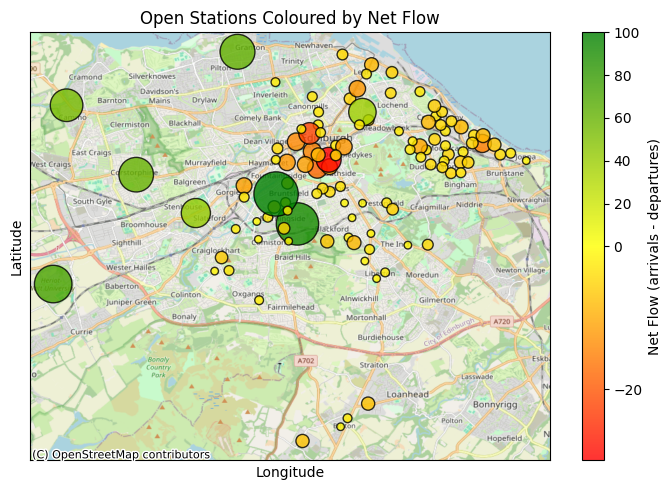

In [21]:
import contextily as ctx
import matplotlib.colors as mcolors
# Make a DataFrame of open stations with lat/lon
df_open = pd.DataFrame({
    'station': open_stations,
    'lat': open_station_lats,
    'lon': open_station_lons
})

# Merge with net_flow from station_util
df_open = df_open.merge(
    station_util[['station', 'net_flow']],
    on='station',
    how='left'  # ensures all open stations are kept
)

# ---- Prepare GeoDataFrame ----
gdf_open = gpd.GeoDataFrame(
    df_open,
    geometry=gpd.points_from_xy(df_open.lon, df_open.lat),
    crs="EPSG:4326"
)

# Convert to Web Mercator
gdf_open_web = gdf_open.to_crs(epsg=3857)

# ---- Marker size ----
sizes = np.abs(gdf_open_web["net_flow"]) * 10 + 20

# ---- Colormap ----
cmap = mcolors.LinearSegmentedColormap.from_list(
    "flow_cmap", ["red", "yellow", "green"]
)

norm = mcolors.TwoSlopeNorm(
    vmin=gdf_open_web["net_flow"].min(),
    vcenter=0,
    vmax=gdf_open_web["net_flow"].max()
)

# ---- Plot ----
fig, ax = plt.subplots(figsize=(7, 5))
sc = ax.scatter(
    gdf_open_web.geometry.x,
    gdf_open_web.geometry.y,
    c=gdf_open_web["net_flow"],
    cmap=cmap,
    norm=norm,
    s=sizes,
    alpha=0.8,
    edgecolor='k',
    zorder=5
)

ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
cbar = plt.colorbar(sc, ax=ax, shrink=1)
cbar.set_label("Net Flow (arrivals - departures)")

ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Open Stations Coloured by Net Flow")
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()

plt.savefig("station_flow_plot.png") 

plt.show()


#### Coverage by Category Plot

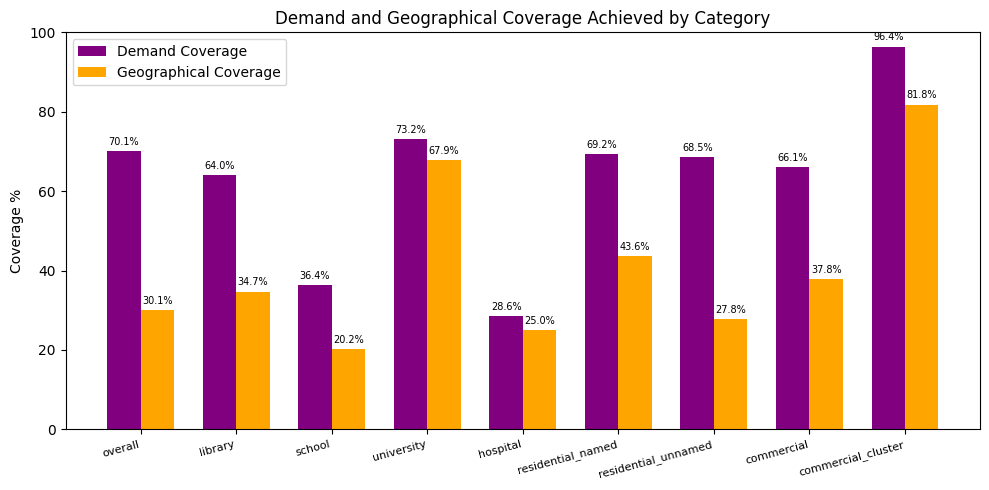

In [22]:
import matplotlib.pyplot as plt
import numpy as np

# Your categories (excluding 'overall' for indexing)
categories = [
    'library', 'school', 'university', 'hospital',
    'residential_named', 'residential_unnamed', 'commercial', 'commercial_cluster'
]

# Initialize lists to store coverage percentages
demand_coverage = []
geographical_coverage = []

# First, compute overall coverage
total_served_demand = served.sum()
total_demand = D.sum()
total_geo_covered = sum(z[j].getSolution() for j in range(len(D)))

demand_coverage.append(total_served_demand / total_demand * 100)
geographical_coverage.append(total_geo_covered / len(D) * 100)

# Then per-category coverage
for cat in categories:
    idxs = category_indices[cat]        # indices for this category
    cat_demand = D[idxs].sum()
    cat_served = served[idxs].sum()
    cat_geo_covered = sum(z[j].getSolution() for j in idxs)

    demand_frac = cat_served / cat_demand if cat_demand > 0 else 0
    geo_frac = cat_geo_covered / len(idxs) if len(idxs) > 0 else 0

    demand_coverage.append(demand_frac * 100)
    geographical_coverage.append(geo_frac * 100)

# Add 'overall' to x-axis labels
x_labels = ['overall'] + categories

# Plot
x_plotting = np.arange(len(x_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x_plotting - width/2, demand_coverage, width, label='Demand Coverage', color='purple')
rects2 = ax.bar(x_plotting + width/2, geographical_coverage, width, label='Geographical Coverage', color='orange')

ax.set_ylabel('Coverage %')
ax.set_title('Demand and Geographical Coverage Achieved by Category')
ax.set_xticks(x_plotting)
ax.set_xticklabels(x_labels, rotation=15, ha='right', fontsize=8)
ax.set_ylim(0, 100)
ax.legend()

# Add value labels
def add_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.1f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=7)

add_labels(rects1)
add_labels(rects2)

plt.savefig("coverage_plot.png") 

plt.tight_layout()
plt.show()


### Expansion Analysis

In [23]:
threshold = 10  # you can vary this to see how many stations exceed certain net flows

# ---- Select stations where |net flow| >= threshold for potential adjustment ----
stations_to_change = station_util[np.abs(station_util['net_flow']) >= threshold].copy()
print(f"Number of stations with |net flow| >= {threshold}: {len(stations_to_change)}")

# ---- Get current bikes from the model ----
current_bikes_list = [int(price.getSolution(x[i])) for i in stations_to_change['station']]
stations_to_change['current_bikes'] = current_bikes_list

# ---- Minimum bikes based on min docks ----
min_bikes_per_station = int(np.ceil(min_docks_per_station / 2))

# ---- Fraction of trips to cover ----
coverage_fraction = 0.4

# ---- Compute bikes to add/remove based on scaled net flow and trips per bike ----
def compute_bikes_change(row):
    scaled_net_flow = coverage_fraction * row['net_flow']  # scale to desired coverage
    if scaled_net_flow > 0:
        # Required bikes to satisfy outgoing net flow
        bikes_needed = ceil(scaled_net_flow / s_trips_per_bike_per_day)
        return max(0, bikes_needed - row['current_bikes'])
    else:
        # Bikes to remove for negative net flow (limited by min bikes)
        bikes_to_remove = floor(scaled_net_flow / s_trips_per_bike_per_day)
        return max(bikes_to_remove, min_bikes_per_station - row['current_bikes'])

stations_to_change['bikes_change'] = stations_to_change.apply(compute_bikes_change, axis=1)

# ---- Compute new number of bikes (enforcing minimum) ----
stations_to_change['new_bikes'] = stations_to_change.apply(
    lambda row: max(row['current_bikes'] + row['bikes_change'], min_bikes_per_station), axis=1
)

# ---- Compute docks: always exactly 2 × new bikes ----
stations_to_change['new_docks'] = 2 * stations_to_change['new_bikes']

stations_to_change


Number of stations with |net flow| >= 10: 21


NameError: name 'ceil' is not defined

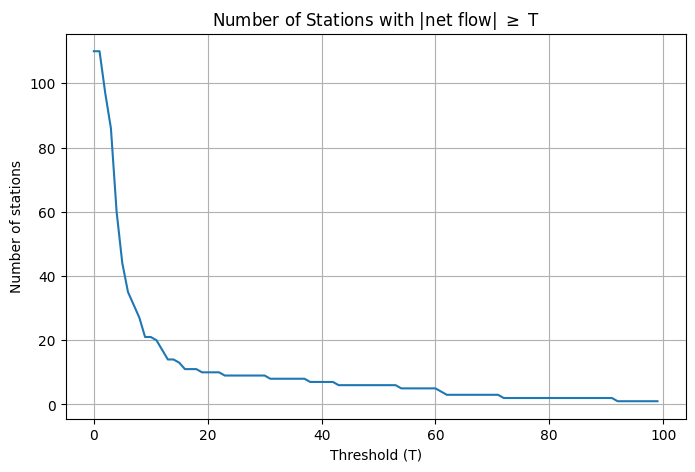

In [24]:
threshold_values = np.arange(0, 100, 1)
counts = []

for th in threshold_values:
    counts.append(np.sum(np.abs(station_util["net_flow"]) >= th))

plt.figure(figsize=(8, 5))
plt.plot(threshold_values, counts)
plt.xlabel("Threshold (T)")
plt.ylabel("Number of stations")
plt.title(r"Number of Stations with |net flow| $\geq$ T")
plt.grid(True)

plt.savefig("threshold_flow_plot.png") 

plt.show()


### Analysis of How Well Model Serves Each Scenario

In [25]:
import numpy as np

# Number of scenarios to evaluate
num_scenarios = D_scenarios.shape[0]

# Allocate output arrays
percent_trips_served = np.zeros(num_scenarios)
percent_POIs_geometrically_covered = np.zeros(num_scenarios)
percent_POIs_served_by_category = {cat: np.zeros(num_scenarios) for cat in categories}

# Precompute geometric coverage (same for every scenario)
geometric_cover_mask = np.array([
    any(a[j, i] == 1 and distances[j, i] <= coverage_radius_km for i in open_stations)
    for j in range(num_pois)
])
percent_geometric_coverage = geometric_cover_mask.mean() * 100  # fixed number

# Compute station capacities (fixed)
station_capacity = {i: price.getSolution(x[i]) * s_trips_per_bike_per_day for i in open_stations}

# ---- SCENARIO LOOP ----
for s in range(num_scenarios):

    # --- Scenario demand (raw) ---
    D_s = D_scenarios[s].copy()

    # ----- Compute effective demand (elasticity + subsidy) -----
    raw_subsidy = np.sum(s_e[:, None] * n, axis=0)
    num_subsidised = np.sum(n, axis=0)

    subsidy_per_trip = np.zeros_like(raw_subsidy)
    mask = num_subsidised > 0
    subsidy_per_trip[mask] = raw_subsidy[mask] / num_subsidised[mask]
    subsidy_per_trip = np.minimum(subsidy_per_trip, p)

    price_sub = np.maximum(p - subsidy_per_trip, 0.01)

    frac_sub = np.zeros_like(D_s)
    positive = D_s > 0
    frac_sub[positive] = num_subsidised[positive] / D_s[positive]

    D_sub = np.zeros_like(D_s)
    D_unsub = np.zeros_like(D_s)
    D_sub[positive] = D_s[positive] * frac_sub[positive] * (price_sub[positive] / p) ** PED
    D_unsub[positive] = D_s[positive] * (1 - frac_sub[positive])

    D_eff = D_sub + D_unsub

    # -------- Compute served demand --------
    served_demand = np.zeros(num_pois)

    for j in range(num_pois):
        # Stations that cover this POI
        covering_stations = [
            i for i in open_stations 
            if a[j, i] == 1 and distances[j, i] <= coverage_radius_km
        ]

        if not covering_stations:
            continue  # no service

        # Total available capacity
        cap = sum(station_capacity[i] for i in covering_stations)

        # Serve min(effective demand, capacity)
        served_demand[j] = min(D_eff[j], cap)

    # ---- Save metrics ----

    # Percentage of effective demand served
    percent_trips_served[s] = 100 * served_demand.sum() / D_eff.sum() if D_eff.sum() > 0 else 0

    # Geometric coverage (constant across scenarios)
    percent_POIs_geometrically_covered[s] = percent_geometric_coverage

    # Categorywise POI coverage
    for cat, idx in category_indices.items():
        if len(idx) > 0:
            percent_POIs_served_by_category[cat][s] = 100 * (served_demand[idx] > 0).mean()

# ---- Summary Stats ----
print("Average % trips served:", np.mean(percent_trips_served))
print("Geometric coverage % (fixed):", percent_geometric_coverage)

print("\nCategory POI coverage (percent):")
for cat in categories:
    print(cat, ":", np.mean(percent_POIs_served_by_category[cat]))


Average % trips served: 68.05300428541561
Geometric coverage % (fixed): 30.0561797752809

Category POI coverage (percent):
library : 26.53061224489796
school : 14.285714285714281
university : 67.85714285714289
hospital : 12.5
residential_named : 43.63636363636363
residential_unnamed : 7.9316656497864555
commercial : 25.59055118110236
commercial_cluster : 81.81818181818184


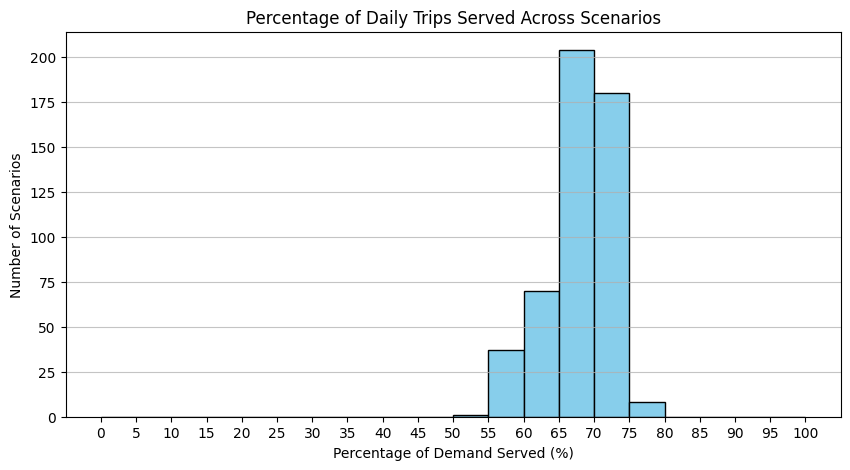

In [26]:
# Define histogram bins: 0-5, 5-10, ..., 95-100
bins = np.arange(0, 105, 5) 

plt.figure(figsize=(10, 5))
plt.hist(percent_trips_served, bins=bins, edgecolor='k', color='skyblue')
plt.title("Percentage of Daily Trips Served Across Scenarios")
plt.xlabel("Percentage of Demand Served (%)")
plt.ylabel("Number of Scenarios")
plt.xticks(bins)
plt.grid(axis='y', alpha=0.75)

plt.savefig("scenario_trip_coverage_plot.png") 

plt.show()


#### Plots of Temporal Multipliers

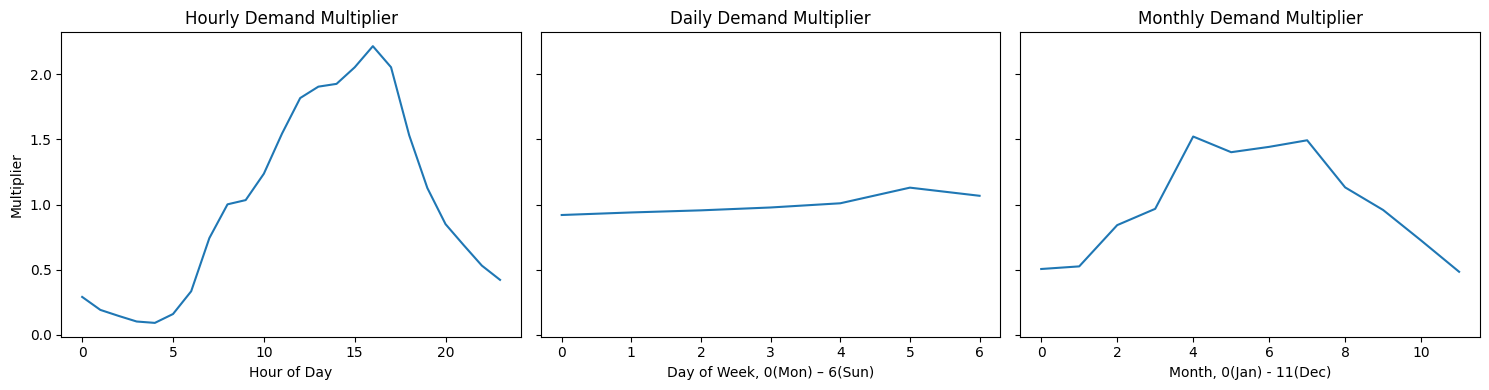

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

# Hour-of-day plot
axes[0].plot(range(len(f_hour)), f_hour)
axes[0].set_title("Hourly Demand Multiplier")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Multiplier")

# Day-of-week plot
axes[1].plot(range(len(f_dow)), f_dow)
axes[1].set_title("Daily Demand Multiplier")
axes[1].set_xlabel("Day of Week, 0(Mon) – 6(Sun)")

# Month-of-year plot
axes[2].plot(range(len(f_month)), f_month)
axes[2].set_title("Monthly Demand Multiplier")
axes[2].set_xlabel("Month, 0(Jan) - 11(Dec)")

plt.tight_layout()

plt.savefig("multiplier_plot.png") 

plt.show()